# **Import and preprocessing**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [2]:
#Import dataset and set sort ascending index "Date"
df = pd.read_csv("/content/HPG-Historical-Data.csv", parse_dates=['Date'], index_col='Date', sep=',')
df = df.sort_index(ascending=True)
print(df.head())

               Price      Open      High       Low    Vol. Change %
Date                                                               
2019-03-01  12,053.9  11,825.1  12,053.9  11,825.1  12.62M    1.93%
2019-03-04  12,441.0  12,229.8  12,441.0  12,212.2  13.74M    3.21%
2019-03-05  12,335.4  12,353.0  12,529.0  12,300.2  15.62M   -0.85%
2019-03-06  12,317.8  12,317.8  12,388.2  12,106.6   9.24M   -0.14%
2019-03-07  12,001.1  12,317.8  12,335.4  12,001.1  12.47M   -2.57%


In [3]:
#Read type of dataset
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('M', '').replace('K', '')) * (1e6 if 'M' in x else 1e3))

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,12053.9,11825.1,12053.9,11825.1,12620000.0,0.0193
2019-03-04,12441.0,12229.8,12441.0,12212.2,13740000.0,0.0321
2019-03-05,12335.4,12353.0,12529.0,12300.2,15620000.0,-0.0085
2019-03-06,12317.8,12317.8,12388.2,12106.6,9240000.0,-0.0014
2019-03-07,12001.1,12317.8,12335.4,12001.1,12470000.0,-0.0257


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998828  0.999506  0.999455  0.414316  0.015184
Open      0.998828  1.000000  0.999496  0.999487  0.412443 -0.025176
High      0.999506  0.999496  1.000000  0.999366  0.422356 -0.006228
Low       0.999455  0.999487  0.999366  1.000000  0.403603 -0.006027
Vol.      0.414316  0.412443  0.422356  0.403603  1.000000  0.008307
Change %  0.015184 -0.025176 -0.006228 -0.006027  0.008307  1.000000


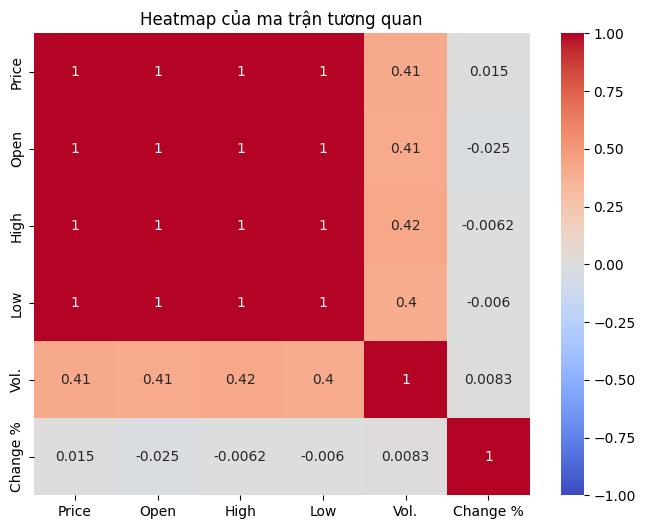

In [5]:
#Find best features for VARMA model by evaluate each features using heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [6]:
#Choose best features from heatmap
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,12053.9,11825.1,12053.9,11825.1
2019-03-04,12441.0,12229.8,12441.0,12212.2
2019-03-05,12335.4,12353.0,12529.0,12300.2
2019-03-06,12317.8,12317.8,12388.2,12106.6
2019-03-07,12001.1,12317.8,12335.4,12001.1


# **Split train, test by 90:10**

In [7]:
#Split train and test by 9:1
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1313
1181
132


In [ ]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

VARMA(1, 1) - Error: 5-th leading minor of the array is not positive definite
VARMA(1, 2) - Error: 5-th leading minor of the array is not positive definite
VARMA(1, 3) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.72365e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25548e-27): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estima

VARMA(1, 4) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 1) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 2) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1544e-24): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/

VARMA(2, 3) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 4) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.75867e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


KeyboardInterrupt: 

In [8]:
#Create model and training
model = VARMAX(train, order=(4, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1181
Model:                           VARMA(4,1)   Log Likelihood              -32457.858
                                + intercept   AIC                          65103.716
Date:                      Tue, 18 Jun 2024   BIC                          65580.683
Time:                              17:49:39   HQIC                         65283.527
Sample:                                   0                                         
                                     - 1181                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):     0.00, 0.05, 0.00, 0.01   Jarque-Bera (JB):   553.80, 63413.90, 2518.17, 790.10
Prob(Q):                0.99, 0.82, 0.97, 0.91   Prob(JB):                      0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 5.81,

In [9]:
#Forecast test dataset
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                   Price          Open          High           Low
Date                                                              
2023-11-16  24612.212475  24594.337991  25033.502123  24163.850047
2023-11-17  24518.040043  24631.189767  24994.016787  24126.452619
2023-11-20  24495.960653  24510.344400  24873.067833  24145.429260
2023-11-21  24461.856060  24502.821032  24866.489426  24127.007745
2023-11-22  24418.680825  24475.769376  24830.351652  24081.628922


**MAE, MAPE, RMSE**

In [10]:
#Determine MEAN and MAPE, RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2270.4296945542
Mean Absolute Percentage Error (MAPE): 0.08351797411797728
Root Mean Squared Error (RMSE): 2755.1542588195066


# **Forecast next 30,60,90 days**

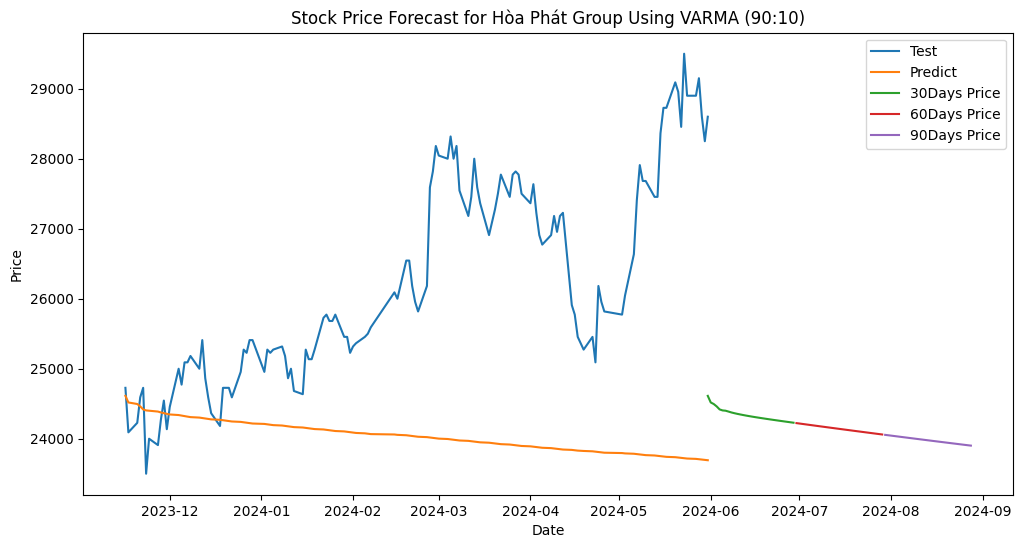

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_90 = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_60 = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_30 = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

plt.plot(test.index, test["Price"], label='Test')

plt.plot(test.index, forecast["Price"], label='Predict')

plt.plot(forecast_df_30.index, forecast_df_30["Price"], label='30Days Price')

filtered_df_60 = forecast_df_60.iloc[30:60]

plt.plot(filtered_df_60.index, filtered_df_60["Price"], label='60Days Price')

filtered_df_90 = forecast_df_90.iloc[60:90]

plt.plot(filtered_df_90.index, filtered_df_90["Price"], label='90Days Price')

plt.title('Stock Price Forecast for Hòa Phát Group Using VARMA (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

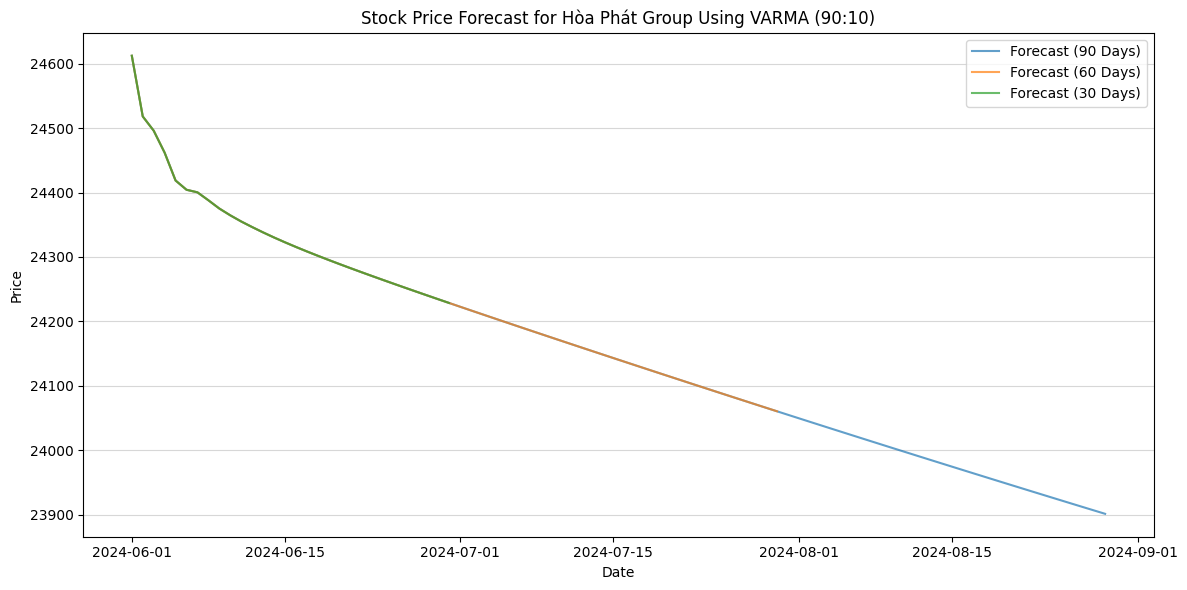

In [12]:
# Forecasting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizons = [90, 60, 30]
forecast_dfs = {}

for horizon in forecast_horizons:
    forecast = model_fit.forecast(steps=horizon)
    forecast_df = pd.DataFrame(
        forecast,
        index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=horizon, freq='D'),
        columns=df.columns
    )
    forecast_dfs[horizon] = forecast_df

for horizon, forecast_df in forecast_dfs.items():
    plt.plot(forecast_df.index, forecast_df["Price"],
             label=f'Forecast ({horizon} Days)', alpha=0.7)

plt.title('Stock Price Forecast for Hòa Phát Group Using VARMA (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()
